# Document Layout Analysis Using SSD

## About the network:
1. Paper on SSD: https://arxiv.org/abs/1512.02325

2. Blog-1 on SSD: https://towardsdatascience.com/review-ssd-single-shot-detector-object-detection-851a94607d11

3. Blog-2 on SSD: https://medium.com/@jonathan_hui/ssd-object-detection-single-shot-multibox-detector-for-real-time-processing-9bd8deac0e06

# Table of Contents

### 1. Installation Instructions
### 2. Use trained Model for Document Layout Analysis
### 3. How to train using PRImA Layout Analysis Dataset

# Installation

- Run these commands

    - git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

    - cd Monk_Object_Detection/1_gluoncv_finetune/installation

- Select the right requirements file and run

    - cat requirements_cuda10.1.txt | xargs -n 1 -L 1 pip install

In [ ]:
! git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

In [ ]:
# For colab use the command below
#! cd Monk_Object_Detection/1_gluoncv_finetune/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install


# For Local systems and cloud select the right CUDA version
!cd Monk_Object_Detection/1_gluoncv_finetune/installation && cat requirements_cuda10.1.txt | xargs -n 1 -L 1 pip install

# Use Already Trained Model for Demo

In [2]:
import os
import sys
sys.path.append("Monk_Object_Detection/1_gluoncv_finetune/lib/");

In [3]:
from inference_prototype import Infer

In [ ]:
#Download trained model

In [ ]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E6T7RKGwy-v1MUxVJm-rxt5XcRyr2SQ7' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E6T7RKGwy-v1MUxVJm-rxt5XcRyr2SQ7" -O obj_dla_ssd512_trained.zip && rm -rf /tmp/cookies.txt

In [5]:
! unzip -qq obj_dla_ssd512_trained.zip

In [8]:
model_name = "ssd_512_vgg16_atrous_coco";
params_file = "dla_ssd512/dla_ssd512-vgg16.params";
class_list = ["paragraph", "heading", "credit", "footer", "drop-capital", "floating", "noise", "maths", "header", "caption", "image", "linedrawing", "graphics", "fname", "page-number", "chart", "separator", "table"];

In [9]:
gtf = Infer(model_name, params_file, class_list, use_gpu=True);

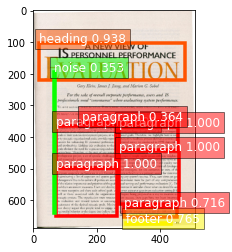

<Figure size 432x288 with 0 Axes>

In [11]:
img_name = "Test_Images/test1.jpg"; 
visualize = True;
thresh = 0.3;
output = gtf.run(img_name, visualize=visualize, thresh=thresh);

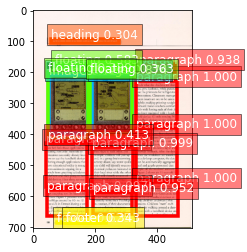

<Figure size 432x288 with 0 Axes>

In [13]:
img_name = "Test_Images/test2.jpg"; 
visualize = True;
thresh = 0.3;
output = gtf.run(img_name, visualize=visualize, thresh=thresh);

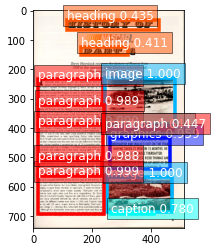

<Figure size 432x288 with 0 Axes>

In [14]:
img_name = "Test_Images/test3.jpg"; 
visualize = True;
thresh = 0.4;
output = gtf.run(img_name, visualize=visualize, thresh=thresh);

# Train Your Own Model

## Dataset Credits
- https://www.primaresearch.org/datasets/Layout_Analysis

In [ ]:
#Download Dataset

In [ ]:
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1iBfafT1WHAtKAW0a1ifLzvW5f0ytm2i_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1iBfafT1WHAtKAW0a1ifLzvW5f0ytm2i_" -O PRImA_Layout_Analysis_Dataset.zip && rm -rf /tmp/cookies.txt

In [2]:
! unzip -qq PRImA_Layout_Analysis_Dataset.zip

# Data Preprocessing

### Library for Data Augmentation
Refer to https://github.com/albumentations-team/albumentations for more details

In [ ]:
! pip install albumentations

In [3]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
import glob
import matplotlib.pyplot as plt
import xmltodict
import json
from tqdm.notebook import tqdm
from pycocotools.coco import COCO

In [15]:
root_dir = "PRImA Layout Analysis Dataset/";
img_dir = "Images/";
anno_dir = "XML/";
final_root_dir="Document_Layout_Analysis/" #Directory for jpeg and augmented images

In [10]:
if not os.path.exists(final_root_dir):
    os.makedirs(final_root_dir)

if not os.path.exists(final_root_dir+img_dir):
    os.makedirs(final_root_dir+img_dir)

## TIFF Image Format to JPEG Image Format

In [16]:
for name in glob.glob(root_dir+img_dir+'*.tif'):
    im = Image.open(name)
    name = str(name).rstrip(".tif")
    name = str(name).lstrip(root_dir)
    name = str(name).lstrip(img_dir)
    im.save(final_root_dir+ img_dir+ name + '.jpg', 'JPEG')

# Format Conversion and Data Augmentation

## Given format- VOC Format

### Dataset Directory Structure

    ./PRImA Layout Analysis Dataset/ (root_dir)
          |
          |-----------Images (img_dir)
          |              |
          |              |------------------img1.jpg
          |              |------------------img2.jpg
          |              |------------------.........(and so on)
          |
          |
          |-----------Annotations (anno_dir)
          |              |
          |              |------------------img1.xml
          |              |------------------img2.xml
          |              |------------------.........(and so on)
          


## Required Format- Monk Format

### Dataset Directory Structure

    ./Document_Layout_Analysis/ (final_root_dir)
          |
          |-----------Images (img_dir)
          |              |
          |              |------------------img1.jpg
          |              |------------------img2.jpg
          |              |------------------.........(and so on)
          |
          |
          |-----------train_labels.csv (anno_file)
          
          
### Annotation file format

           | Id         | Labels                                 |
           | img1.jpg   | x1 y1 x2 y2 label1 x1 y1 x2 y2 label2  |
           
- Labels:  xmin ymin xmax ymax label
- xmin, ymin - top left corner of bounding box
- xmax, ymax - bottom right corner of bounding box

In [18]:
files = os.listdir(root_dir + anno_dir);

In [19]:
combined = [];

### Data Augmentation Function

In [20]:
def augmentData(fname, boxes):
    image = cv2.imread(final_root_dir+img_dir+fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
    transform = A.Compose([
        A.IAAPerspective(p=0.7),   
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=5, p=0.5),
        A.IAAAdditiveGaussianNoise(),
        A.ChannelShuffle(),
        A.RandomBrightnessContrast(),
        A.RGBShift(p=0.8),
        A.HueSaturationValue(p=0.8)
        ], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.2))
    
    for i in range(1, 9):
        label=""
        transformed = transform(image=image, bboxes=boxes)
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        #print(transformed_bboxes)
        flag=False
        for box in transformed_bboxes:
            x_min, y_min, x_max, y_max, class_name = box
            if(xmax<=xmin or ymax<=ymin):
                flag=True
                break
            label+= str(int(x_min))+' '+str(int(y_min))+' '+str(int(x_max))+' '+str(int(y_max))+' '+class_name+' '
                        
        if(flag):
            continue
        cv2.imwrite(final_root_dir+img_dir+str(i)+fname, transformed_image)
        label=label[:-1]
        combined.append([str(i) + fname, label])


# VOC to Monk Format Conversion
Applying Data Augmentation only on those images which contain atleast 1 minority class so as to reduce bias in the dataset

In [21]:
#label generation for csv
for i in tqdm(range(len(files))):
    box=[];
    augment=False;
    annoFile = root_dir + anno_dir + files[i];
    f = open(annoFile, 'r');
    my_xml = f.read();
    anno= dict(dict(dict(xmltodict.parse(my_xml))['PcGts'])['Page'])
    fname=""
    for j in range(len(files[i])):
        if((files[i][j])>='0' and files[i][j]<='9'):
            fname+=files[i][j];
    fname+=".jpg"
    image = cv2.imread(final_root_dir+img_dir+fname)
    height, width = image.shape[:2]    
    label_str = ""
    for key in anno.keys():
        if(key=='@imageFilename' or key=='@imageWidth' or key=='@imageHeight'):
            continue
        if(key=="TextRegion"):
            if(type(anno["TextRegion"]) == list):
                for j in range(len(anno["TextRegion"])):
                    text=anno["TextRegion"][j]
                    xmin=width
                    ymin=height
                    xmax=0
                    ymax=0
                    if(text["Coords"]):
                        if(text["Coords"]["Point"]):
                            for k in range(len(text["Coords"]["Point"])):
                                coordinates=anno["TextRegion"][j]["Coords"]["Point"][k]
                                xmin= min(xmin, int(coordinates['@x']));
                                ymin= min(ymin, int(coordinates['@y']));
                                xmax= min(max(xmax, int(coordinates['@x'])), width);
                                ymax= min(max(ymax, int(coordinates['@y'])), height);
                            if('@type' in text.keys()):    
                                label_str+= str(xmin)+' '+str(ymin)+' '+str(xmax)+' '+str(ymax)+' '+text['@type']+' '
                                if(xmax<=xmin or ymax<=ymin):
                                    continue
                                tbox=[];
                                tbox.append(xmin)
                                tbox.append(ymin)
                                tbox.append(xmax)
                                tbox.append(ymax)
                                tbox.append(text['@type'])
                                box.append(tbox)
            else:
                text=anno["TextRegion"]
                xmin=width
                ymin=height
                xmax=0
                ymax=0
                if(text["Coords"]):
                    if(text["Coords"]["Point"]):
                        for k in range(len(text["Coords"]["Point"])):
                            coordinates=anno["TextRegion"]["Coords"]["Point"][k]
                            xmin= min(xmin, int(coordinates['@x']));
                            ymin= min(ymin, int(coordinates['@y']));
                            xmax= min(max(xmax, int(coordinates['@x'])), width);
                            ymax= min(max(ymax, int(coordinates['@y'])), height);
                        if('@type' in text.keys()):    
                            label_str+= str(xmin)+' '+str(ymin)+' '+str(xmax)+' '+str(ymax)+' '+text['@type']+' '
                            if(xmax<=xmin or ymax<=ymin):
                                continue
                            tbox=[];
                            tbox.append(xmin)
                            tbox.append(ymin)
                            tbox.append(xmax)
                            tbox.append(ymax)
                            tbox.append(text['@type'])
                            box.append(tbox)
        
        else:
            val=""
            if(key=='GraphicRegion'):
                val="graphics"
                augment=True
            elif(key=='ImageRegion'):
                val="image"
            elif(key=='NoiseRegion'):
                val="noise"
                augment=True
            elif(key=='ChartRegion'):
                val="chart"
                augment=True
            elif(key=='TableRegion'):
                val="table"
                augment=True
            elif(key=='SeparatorRegion'):
                val="separator"
            elif(key=='MathsRegion'):
                val="maths"
                augment=True
            elif(key=='LineDrawingRegion'):
                val="linedrawing"
                augment=True
            else:
                val="frame"
                augment=True

            
            if(type(anno[key]) == list):
                for j in range(len(anno[key])):
                    text=anno[key][j]
                    xmin=width
                    ymin=height
                    xmax=0
                    ymax=0
                    if(text["Coords"]):
                        if(text["Coords"]["Point"]):
                            for k in range(len(text["Coords"]["Point"])):
                                coordinates=anno[key][j]["Coords"]["Point"][k]
                                xmin= min(xmin, int(coordinates['@x']));
                                ymin= min(ymin, int(coordinates['@y']));
                                xmax= min(max(xmax, int(coordinates['@x'])), width);
                                ymax= min(max(ymax, int(coordinates['@y'])), height);
                        label_str+= str(xmin)+' '+str(ymin)+' '+str(xmax)+' '+str(ymax)+' '+ val +' '
                        if(xmax<=xmin or ymax<=ymin):
                            continue
                        tbox=[];
                        tbox.append(xmin)
                        tbox.append(ymin)
                        tbox.append(xmax)
                        tbox.append(ymax)
                        tbox.append(val)
                        box.append(tbox)
            else:
                text=anno[key]
                xmin=width
                ymin=height
                xmax=0
                ymax=0
                if(text["Coords"]):
                    if(text["Coords"]["Point"]):
                        for k in range(len(text["Coords"]["Point"])):
                            coordinates=anno[key]["Coords"]["Point"][k]
                            xmin= min(xmin, int(coordinates['@x']));
                            ymin= min(ymin, int(coordinates['@y']));
                            xmax= min(max(xmax, int(coordinates['@x'])), width);
                            ymax= min(max(ymax, int(coordinates['@y'])), height);  
                        label_str+= str(xmin)+' '+str(ymin)+' '+str(xmax)+' '+str(ymax)+' '+val+' '
                        if(xmax<=xmin or ymax<=ymin):
                            continue
                        tbox=[];
                        tbox.append(xmin)
                        tbox.append(ymin)
                        tbox.append(xmax)
                        tbox.append(ymax)
                        tbox.append(val)
                        box.append(tbox)

    label_str=label_str[:-1]
    combined.append([fname, label_str])

    if(augment):
        augmentData(fname, box)
        

In [22]:
df = pd.DataFrame(combined, columns = ['ID', 'Label']);
df.to_csv(final_root_dir + "/train_labels.csv", index=False);

# Training

In [1]:
import os
import sys

sys.path.append("Monk_Object_Detection/1_gluoncv_finetune/lib/");

In [2]:
from detector_prototype import Detector

In [3]:
gtf = Detector();

In [4]:
root = "Document_Layout_Analysis/";
img_dir = "Images/";
anno_file = "train_labels.csv";
batch_size=8;

In [5]:
gtf.Dataset(root, img_dir, anno_file, batch_size=batch_size);

### Available models
    ssd_300_vgg16_atrous_coco
    ssd_300_vgg16_atrous_voc
    ssd_512_vgg16_atrous_coco
    ssd_512_vgg16_atrous_voc
    ssd_512_resnet50_v1_coco
    ssd_512_resnet50_v1_voc
    ssd_512_mobilenet1.0_voc
    ssd_512_mobilenet1.0_coco
    yolo3_darknet53_voc
    yolo3_darknet53_coco
    yolo3_mobilenet1.0_voc
    yolo3_mobilenet1.0_coco

In [6]:
#vgg16 architecture, with atrous convolutions, pretrained on COCO dataset is used for this task
pretrained = True;         
gpu=True;
model_name = "ssd_512_vgg16_atrous_coco";

In [7]:
gtf.Model(model_name, use_pretrained=pretrained, use_gpu=gpu);

In [10]:
gtf.Set_Learning_Rate(0.003);

In [11]:
epochs=30;
params_file = "saved_model.params";

In [12]:
gtf.Train(epochs, params_file);

[Epoch 0][Batch 0], Speed: 0.340 samples/sec, CrossEntropy=20.430, SmoothL1=7.349
[Epoch 0][Batch 20], Speed: 1.176 samples/sec, CrossEntropy=12.521, SmoothL1=5.808
[Epoch 0][Batch 40], Speed: 2.159 samples/sec, CrossEntropy=11.224, SmoothL1=5.160
[Epoch 0][Batch 60], Speed: 1.375 samples/sec, CrossEntropy=10.177, SmoothL1=4.937
[Epoch 0][Batch 80], Speed: 1.622 samples/sec, CrossEntropy=9.225, SmoothL1=4.885
[Epoch 0][Batch 100], Speed: 1.218 samples/sec, CrossEntropy=8.411, SmoothL1=4.783
[Epoch 0][Batch 120], Speed: 1.050 samples/sec, CrossEntropy=7.783, SmoothL1=4.628
[Epoch 0][Batch 140], Speed: 0.665 samples/sec, CrossEntropy=7.278, SmoothL1=4.395
[Epoch 0][Batch 160], Speed: 1.531 samples/sec, CrossEntropy=6.879, SmoothL1=4.303
[Epoch 0][Batch 180], Speed: 0.746 samples/sec, CrossEntropy=6.547, SmoothL1=4.201
[Epoch 0][Batch 200], Speed: 1.070 samples/sec, CrossEntropy=6.282, SmoothL1=4.167
[Epoch 0][Batch 220], Speed: 1.162 samples/sec, CrossEntropy=6.051, SmoothL1=4.091
[Epoch

[Epoch 5][Batch 0], Speed: 1.202 samples/sec, CrossEntropy=2.481, SmoothL1=2.156
[Epoch 5][Batch 20], Speed: 0.927 samples/sec, CrossEntropy=2.647, SmoothL1=1.914
[Epoch 5][Batch 40], Speed: 0.906 samples/sec, CrossEntropy=2.616, SmoothL1=2.252
[Epoch 5][Batch 60], Speed: 1.720 samples/sec, CrossEntropy=2.614, SmoothL1=2.362
[Epoch 5][Batch 80], Speed: 1.335 samples/sec, CrossEntropy=2.600, SmoothL1=2.327
[Epoch 5][Batch 100], Speed: 1.180 samples/sec, CrossEntropy=2.616, SmoothL1=2.370
[Epoch 5][Batch 120], Speed: 1.605 samples/sec, CrossEntropy=2.625, SmoothL1=2.434
[Epoch 5][Batch 140], Speed: 1.163 samples/sec, CrossEntropy=2.622, SmoothL1=2.454
[Epoch 5][Batch 160], Speed: 1.367 samples/sec, CrossEntropy=2.601, SmoothL1=2.399
[Epoch 5][Batch 180], Speed: 1.381 samples/sec, CrossEntropy=2.597, SmoothL1=2.397
[Epoch 5][Batch 200], Speed: 1.444 samples/sec, CrossEntropy=2.610, SmoothL1=2.405
[Epoch 5][Batch 220], Speed: 1.093 samples/sec, CrossEntropy=2.611, SmoothL1=2.415
[Epoch 5][

[Epoch 10][Batch 0], Speed: 1.509 samples/sec, CrossEntropy=2.504, SmoothL1=1.689
[Epoch 10][Batch 20], Speed: 0.915 samples/sec, CrossEntropy=2.311, SmoothL1=2.273
[Epoch 10][Batch 40], Speed: 1.664 samples/sec, CrossEntropy=2.396, SmoothL1=2.386
[Epoch 10][Batch 60], Speed: 1.311 samples/sec, CrossEntropy=2.366, SmoothL1=2.328
[Epoch 10][Batch 80], Speed: 1.471 samples/sec, CrossEntropy=2.334, SmoothL1=2.248
[Epoch 10][Batch 100], Speed: 0.905 samples/sec, CrossEntropy=2.339, SmoothL1=2.263
[Epoch 10][Batch 120], Speed: 1.183 samples/sec, CrossEntropy=2.336, SmoothL1=2.191
[Epoch 10][Batch 140], Speed: 1.159 samples/sec, CrossEntropy=2.341, SmoothL1=2.244
[Epoch 10][Batch 160], Speed: 0.936 samples/sec, CrossEntropy=2.348, SmoothL1=2.229
[Epoch 10][Batch 180], Speed: 1.113 samples/sec, CrossEntropy=2.341, SmoothL1=2.201
[Epoch 10][Batch 200], Speed: 1.260 samples/sec, CrossEntropy=2.340, SmoothL1=2.212
[Epoch 10][Batch 220], Speed: 1.085 samples/sec, CrossEntropy=2.346, SmoothL1=2.19

[Epoch 14][Batch 360], Speed: 1.356 samples/sec, CrossEntropy=2.219, SmoothL1=2.089
[Epoch 14][Batch 380], Speed: 1.156 samples/sec, CrossEntropy=2.216, SmoothL1=2.078
[Epoch 15][Batch 0], Speed: 1.076 samples/sec, CrossEntropy=2.129, SmoothL1=2.103
[Epoch 15][Batch 20], Speed: 0.853 samples/sec, CrossEntropy=2.209, SmoothL1=2.051
[Epoch 15][Batch 40], Speed: 0.924 samples/sec, CrossEntropy=2.214, SmoothL1=1.899
[Epoch 15][Batch 60], Speed: 0.960 samples/sec, CrossEntropy=2.213, SmoothL1=1.955
[Epoch 15][Batch 80], Speed: 0.881 samples/sec, CrossEntropy=2.220, SmoothL1=1.962
[Epoch 15][Batch 100], Speed: 0.806 samples/sec, CrossEntropy=2.224, SmoothL1=1.999
[Epoch 15][Batch 120], Speed: 1.132 samples/sec, CrossEntropy=2.217, SmoothL1=2.009
[Epoch 15][Batch 140], Speed: 1.480 samples/sec, CrossEntropy=2.218, SmoothL1=2.045
[Epoch 15][Batch 160], Speed: 1.159 samples/sec, CrossEntropy=2.220, SmoothL1=2.054
[Epoch 15][Batch 180], Speed: 0.956 samples/sec, CrossEntropy=2.231, SmoothL1=2.03

[Epoch 19][Batch 320], Speed: 0.838 samples/sec, CrossEntropy=2.119, SmoothL1=2.036
[Epoch 19][Batch 340], Speed: 0.443 samples/sec, CrossEntropy=2.121, SmoothL1=2.034
[Epoch 19][Batch 360], Speed: 0.955 samples/sec, CrossEntropy=2.119, SmoothL1=2.038
[Epoch 19][Batch 380], Speed: 1.150 samples/sec, CrossEntropy=2.115, SmoothL1=2.037
[Epoch 20][Batch 0], Speed: 1.793 samples/sec, CrossEntropy=2.057, SmoothL1=2.209
[Epoch 20][Batch 20], Speed: 0.968 samples/sec, CrossEntropy=1.975, SmoothL1=2.014
[Epoch 20][Batch 40], Speed: 0.768 samples/sec, CrossEntropy=1.998, SmoothL1=2.182
[Epoch 20][Batch 60], Speed: 0.811 samples/sec, CrossEntropy=2.073, SmoothL1=2.127
[Epoch 20][Batch 80], Speed: 0.680 samples/sec, CrossEntropy=2.065, SmoothL1=2.045
[Epoch 20][Batch 100], Speed: 1.548 samples/sec, CrossEntropy=2.102, SmoothL1=2.175
[Epoch 20][Batch 120], Speed: 1.267 samples/sec, CrossEntropy=2.094, SmoothL1=2.152
[Epoch 20][Batch 140], Speed: 1.009 samples/sec, CrossEntropy=2.104, SmoothL1=2.12

[Epoch 24][Batch 280], Speed: 0.618 samples/sec, CrossEntropy=2.058, SmoothL1=1.957
[Epoch 24][Batch 300], Speed: 2.330 samples/sec, CrossEntropy=2.059, SmoothL1=1.962
[Epoch 24][Batch 320], Speed: 1.069 samples/sec, CrossEntropy=2.058, SmoothL1=1.962
[Epoch 24][Batch 340], Speed: 0.966 samples/sec, CrossEntropy=2.057, SmoothL1=1.958
[Epoch 24][Batch 360], Speed: 0.930 samples/sec, CrossEntropy=2.053, SmoothL1=1.951
[Epoch 24][Batch 380], Speed: 1.012 samples/sec, CrossEntropy=2.050, SmoothL1=1.959
[Epoch 25][Batch 0], Speed: 0.871 samples/sec, CrossEntropy=2.141, SmoothL1=1.410
[Epoch 25][Batch 20], Speed: 0.884 samples/sec, CrossEntropy=2.031, SmoothL1=2.035
[Epoch 25][Batch 40], Speed: 0.566 samples/sec, CrossEntropy=2.049, SmoothL1=2.037
[Epoch 25][Batch 60], Speed: 1.477 samples/sec, CrossEntropy=2.049, SmoothL1=2.028
[Epoch 25][Batch 80], Speed: 1.322 samples/sec, CrossEntropy=2.057, SmoothL1=1.999
[Epoch 25][Batch 100], Speed: 1.056 samples/sec, CrossEntropy=2.063, SmoothL1=1.94

[Epoch 29][Batch 240], Speed: 0.933 samples/sec, CrossEntropy=1.990, SmoothL1=1.857
[Epoch 29][Batch 260], Speed: 0.931 samples/sec, CrossEntropy=1.985, SmoothL1=1.840
[Epoch 29][Batch 280], Speed: 0.965 samples/sec, CrossEntropy=1.990, SmoothL1=1.843
[Epoch 29][Batch 300], Speed: 1.518 samples/sec, CrossEntropy=1.989, SmoothL1=1.858
[Epoch 29][Batch 320], Speed: 1.252 samples/sec, CrossEntropy=1.991, SmoothL1=1.893
[Epoch 29][Batch 340], Speed: 0.961 samples/sec, CrossEntropy=1.996, SmoothL1=1.916
[Epoch 29][Batch 360], Speed: 3.016 samples/sec, CrossEntropy=1.997, SmoothL1=1.923
[Epoch 29][Batch 380], Speed: 1.066 samples/sec, CrossEntropy=1.996, SmoothL1=1.914


# Inference

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/1_gluoncv_finetune/lib/");

In [2]:
from inference_prototype import Infer

In [8]:
model_name = "ssd_512_vgg16_atrous_coco";
params_file = "saved_model.params";
class_list = ["paragraph", "heading", "credit", "footer", "drop-capital", "floating", "noise", "maths", "header", "caption", "image", "linedrawing", "graphics", "fname", "page-number", "chart", "separator", "table"];

In [9]:
gtf = Infer(model_name, params_file, class_list, use_gpu=True);

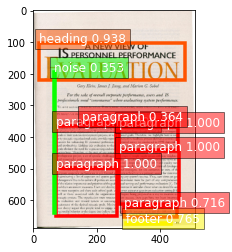

<Figure size 432x288 with 0 Axes>

In [11]:
img_name = "Test_Images/test1.jpg"; 
visualize = True;
thresh = 0.3;
output = gtf.run(img_name, visualize=visualize, thresh=thresh);

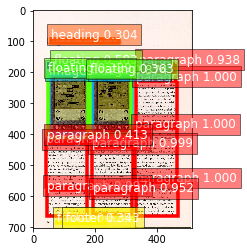

<Figure size 432x288 with 0 Axes>

In [63]:
img_name = "Test_Images/test2.jpg"; 
visualize = True;
thresh = 0.3;
output = gtf.run(img_name, visualize=visualize, thresh=thresh);

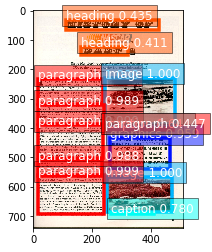

<Figure size 432x288 with 0 Axes>

In [66]:
img_name = "Test_Images/test3.jpg"; 
visualize = True;
thresh = 0.4;
output = gtf.run(img_name, visualize=visualize, thresh=thresh);

The model is performing well in identifying objects with very high confidence but it is biased a lot towards paragraphs. Its performance can be improved by using bigger batch size, training for more epochs and more data augmentation techniques to reduce bias.